In [1]:
pip install neo4j


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Installing backend dependencies ... - \ done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for neo4j: filename=neo4j-5.13.0-py3-none-any.whl size=265313 sha256=db85a288f4aad02b38180db2bbb4b5aa1aa8176d5a3828af3f3b208f2cd9e031
  Stored in directory: /root/.cache/pip/wheels/7b/1d/b6/1be3a1e9de57bc832b7fcebbbf884186d8155bb6f1cc45be99
Successfully built neo4j
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd 
from neo4j import GraphDatabase, RoutingControl
import matplotlib.pyplot as plt
import time
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
music_info = pd.read_csv("/kaggle/input/million-song-dataset-spotify-lastfm/Music Info.csv")
user_info = pd.read_csv("/kaggle/input/million-song-dataset-spotify-lastfm/User Listening History.csv")

In [4]:
music_info.head


<bound method NDFrame.head of                  track_id                name                 artist  \
0      TRIOREW128F424EAF0      Mr. Brightside            The Killers   
1      TRRIVDJ128F429B0E8          Wonderwall                  Oasis   
2      TROUVHL128F426C441     Come as You Are                Nirvana   
3      TRUEIND128F93038C4         Take Me Out        Franz Ferdinand   
4      TRLNZBD128F935E4D8               Creep              Radiohead   
...                   ...                 ...                    ...   
50678  TRQYCFV128F9322F50       Ryusei Rocket            アンティック-珈琲店-   
50679  TRHQCSH128F42724B7  Colors Of The Wind                ACIDMAN   
50680  TRZRODK128F92D68D7      The Revelation               coldrain   
50681  TRGLMEM128F9322F63   Koi no Dependence            アンティック-珈琲店-   
50682  TRIPFKO128F42383FE         Hide & Seek  9mm Parabellum Bullet   

                                     spotify_preview_url  \
0      https://p.scdn.co/mp3-preview/4d26180e

In [5]:
# Going to create a baisc knowledge graph connecting, artists, songs and their genres

# Select only the required columns

kg_data = music_info[["track_id", "name", "artist", "tags"]]

# There exist only a couple of hundred songs with an NA value in their tags.
# For the sake of simplicity I am dorpping all rows with an NA value.
kg = kg_data.dropna()
kg.describe()

,track_id,name,artist,tags
count,49556,49556,49556,49556
unique,49556,49556,8065,20057
top,TRIOREW128F424EAF0,Mr. Brightside,The Rolling Stones,country
freq,1,1,132,506


In [6]:
def get_tag_list(line):
    # Cleans the tags column and covert it to a list instead of comma seperated vals
    return list(line.split(", "))

kg['tags'] = kg['tags'].map(get_tag_list)

kg.head

/tmp/ipykernel_20/4263779555.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kg['tags'] = kg['tags'].map(get_tag_list)


<bound method NDFrame.head of                  track_id                name                 artist  \
0      TRIOREW128F424EAF0      Mr. Brightside            The Killers   
1      TRRIVDJ128F429B0E8          Wonderwall                  Oasis   
2      TROUVHL128F426C441     Come as You Are                Nirvana   
3      TRUEIND128F93038C4         Take Me Out        Franz Ferdinand   
4      TRLNZBD128F935E4D8               Creep              Radiohead   
...                   ...                 ...                    ...   
50675  TRXWSIN128F9339A11  Infinite Love Song      Maximilian Hecker   
50677  TRPIGDW12903CDEB2D     Slip of the Lip                   Fact   
50679  TRHQCSH128F42724B7  Colors Of The Wind                ACIDMAN   
50680  TRZRODK128F92D68D7      The Revelation               coldrain   
50682  TRIPFKO128F42383FE         Hide & Seek  9mm Parabellum Bullet   

                                                    tags  
0      [rock, alternative, indie, alternative_

In [7]:
#Connect to neo4j sandbox
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response


conn = Neo4jConnection(uri="bolt://44.200.108.136:7687", 
                       user="neo4j",              
                       pwd="apparatuses-recapitulation-rolls")

In [8]:
# Map only unique values into the graph
conn.query('CREATE CONSTRAINT papers IF NOT EXISTS FOR (s:Song) REQUIRE s.id IS UNIQUE')
conn.query('CREATE CONSTRAINT authors IF NOT EXISTS FOR (a:Artist) REQUIRE a.name IS UNIQUE')
conn.query('CREATE CONSTRAINT tags IF NOT EXISTS FOR (t:Tag) REQUIRE t.tag IS UNIQUE')

[]

In [9]:

def add_tags(tags):
    # Adds category nodes to the Neo4j graph.
    query = '''
            UNWIND $rows AS row
            MERGE (t:Tag {tag: row.tags})
            RETURN count(*) as total
            '''
    return conn.query(query, parameters = {'rows':tags.to_dict('records')})


def add_artists(rows, batch_size=10000):
    # Adds author nodes to the Neo4j graph as a batch job.
    query = '''
            UNWIND $rows AS row
            MERGE (a:Artist {name: row.artist})
            RETURN count(*) as total
            '''
    return insert_data(query, rows, batch_size)


def insert_data(query, rows, batch_size = 10000):
    # Function to handle the updating the Neo4j database in batch mode.
    
    total = 0
    batch = 0
    start = time.time()
    result = None
    
    while batch * batch_size < len(rows):

        res = conn.query(query, 
                         parameters = {'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        total += res[0]['total']
        batch += 1
        result = {"total":total, 
                  "batches":batch, 
                  "time":time.time()-start}
        print(result)
        
    return result

In [10]:

def add_songs(rows, batch_size=5000):
   # Adds paper nodes and (:Author)--(:Paper) and 
   # (:Paper)--(:Category) relationships to the Neo4j graph as a 
   # batch job.
 
   query = '''
   UNWIND $rows as row
   MERGE (s:Song {id:row.id}) ON CREATE SET s.title = row.song
   
   // connect tags
   WITH row, s
   UNWIND row.tags AS tag_name
   MATCH (t:Tag {tag: tag_name})
   MERGE (s)-[:IN_CATEGORY]->(t)
   
   // connect artists
   WITH distinct row, s // reduce cardinality
   UNWIND row.artist AS author
   MATCH (a:Artist {name: author})
   MERGE (a)-[:WROTE]->(s)
   RETURN count(distinct s) as total
   '''
 
   return insert_data(query, rows, batch_size)

In [11]:
tags = pd.DataFrame(kg[['tags']])
artists = pd.DataFrame(kg[['artist']])
kg.rename(columns={'name':'song'},
               inplace=True)
kg.rename(columns={'track_id':'id'},
               inplace=True)



kg.head


/tmp/ipykernel_20/979307866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kg.rename(columns={'name':'song'},
/tmp/ipykernel_20/979307866.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kg.rename(columns={'track_id':'id'},


<bound method NDFrame.head of                        id                song                 artist  \
0      TRIOREW128F424EAF0      Mr. Brightside            The Killers   
1      TRRIVDJ128F429B0E8          Wonderwall                  Oasis   
2      TROUVHL128F426C441     Come as You Are                Nirvana   
3      TRUEIND128F93038C4         Take Me Out        Franz Ferdinand   
4      TRLNZBD128F935E4D8               Creep              Radiohead   
...                   ...                 ...                    ...   
50675  TRXWSIN128F9339A11  Infinite Love Song      Maximilian Hecker   
50677  TRPIGDW12903CDEB2D     Slip of the Lip                   Fact   
50679  TRHQCSH128F42724B7  Colors Of The Wind                ACIDMAN   
50680  TRZRODK128F92D68D7      The Revelation               coldrain   
50682  TRIPFKO128F42383FE         Hide & Seek  9mm Parabellum Bullet   

                                                    tags  
0      [rock, alternative, indie, alternative_

In [12]:
tags = tags.explode('tags') \
                       .drop_duplicates(subset=['tags'])

artists=artists.explode('artist').drop_duplicates(subset=['artist'])

add_tags(tags)
add_artists(artists)
add_songs(kg)

{'total': 8065, 'batches': 1, 'time': 0.8969235420227051}
{'total': 5000, 'batches': 1, 'time': 1.408832311630249}
{'total': 10000, 'batches': 2, 'time': 2.7806875705718994}
{'total': 15000, 'batches': 3, 'time': 4.343375205993652}
{'total': 20000, 'batches': 4, 'time': 5.69096302986145}
{'total': 25000, 'batches': 5, 'time': 7.229658126831055}
{'total': 30000, 'batches': 6, 'time': 8.403539180755615}
{'total': 35000, 'batches': 7, 'time': 9.92038869857788}
{'total': 40000, 'batches': 8, 'time': 11.0027174949646}
{'total': 45000, 'batches': 9, 'time': 12.495331764221191}
{'total': 49556, 'batches': 10, 'time': 13.354620933532715}


{'total': 49556, 'batches': 10, 'time': 13.354620933532715}

In [13]:
## Now that the data is successfully loaded we can visualize it throught he help of Neo4j.
## I queried 650 points
## MATCH (a:Artist)-[:WROTE]->(s:Song)-[:IN_CATEGORY]->(t:Tag) RETURN a, s, t LIMIT 650
## to get



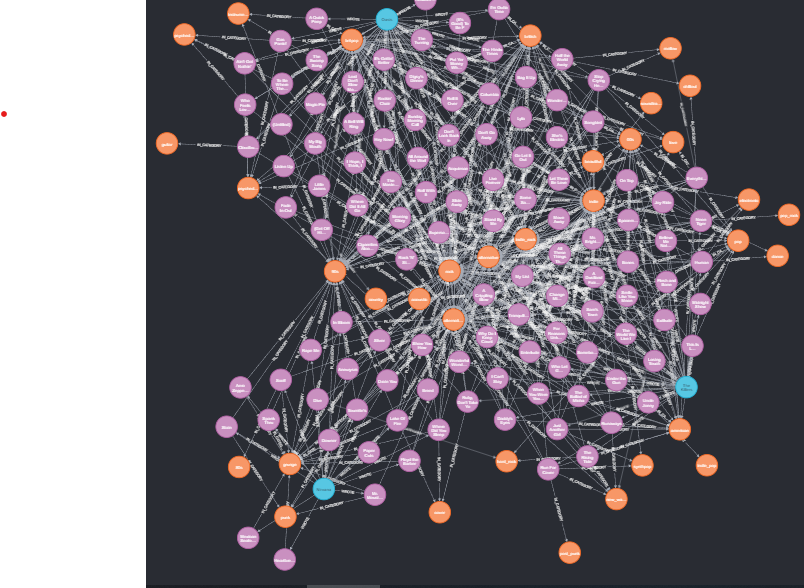

In [14]:
# As can be seen, there are 3 artists connected by songs and genres in this picture.
# They are the blue nodes in the Killers, Nirvana and Oasis.
# This suggests that these are similar artists to each other
# We can use this idea to build a basic reccomendation algorithm.
# First lets build an algorithm to find the shortest path between 2 nodes


In [15]:
query_string = '''MATCH
  (START:Artist {name: 'Oasis'}),
  (END:Artist {name: 'coldrain'}),
  p = shortestPath((START)-[*]-(END))
WITH p
WHERE length(p) > 1
RETURN p'''

conn.query(query_string)

[<Record p=<Path start=<Node element_id='4:001f3cd2-9fdf-42e0-8e10-14ad6dcd9be9:101' labels=frozenset({'Artist'}) properties={'name': 'Oasis'}> end=<Node element_id='4:001f3cd2-9fdf-42e0-8e10-14ad6dcd9be9:8158' labels=frozenset({'Artist'}) properties={'name': 'coldrain'}> size=6>>]